 #  Virginia Expungement Data Science Project 

## DS 5559 - Big Data Analytics
* PaulHicks pdh2d
* Mrityunjaya (Jay) Hombal mh4ey
* Sudhanshu Luthras l3zs
* Mahew Dakolios mrd7f 

## Research Question / Hypothesis

The broad problem: In Virginia, if someone is charged (not necessarily convicted, just charged) with a crime (either felony or misdemeanor), they end up with a criminal record that can be found by criminal background checks that employers run when hiring, landlords run when searching for renters, and banks run when deciding whether to issue a loan. So, having a criminal record can keep a person from a job, housing, and financial opportunity. In effect, this situation creates a permanent underclass in society. Criminal record EXPUNGMENT means that the state courts legally hide these records from other members of the public, so that they no longer are findable by criminal background checks. Currently, records are only expungable if a person was never convicted, and records are only expunged after a long and costly bureaucratic process. That's changing however: in the current legislative session happening right now there are several bills under consideration to expand what is expungable and to make expungement automatic for people with certain kinds of records. Still, there are many unaddressed questions about the nature of expungement and law enforcement (see below for the LAJC's questions), and limitations on the data that can be used to answer these questions.



## Setup

In [168]:
# setup environment variables
%run -i setup.py

# load va file data load script
%run  -i va_court_files_download.py

VA file download script loaded!


In [169]:
# NOTE: IF RUNNING ON RIVINNA set the RIVNNA FLAG to TRUE in settings.py file, default if False
%run -i settings.py

# load spark UDF functions
%run -i utility-functions.py

Imports and display options set...


In [3]:
# To auto-reload modules in jupyter notebook (so that changes in files *.py doesn't require manual reloading):
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%reload_ext autoreload
%autoreload 2

# you can now enable 2x images by just adding the line:
# see: https://gist.github.com/minrk/3301035
%config InlineBackend.figure_format = 'png'

# Data Ingestion and Data Cleaning
Download and Merge Circuit Court Records (10 years)

In [4]:
# download and concat circuit court data from 2009 to 2019 into a dataset and persist to csv
download_and_merge_court_data('circuit')

data directory already existis, files will be deleted
./data/circuit_court_2009_2019.csv.gz file does not exist!
circuit court file download path : ./download-data/circuit
directory does not exist
download directory ./download-data/circuit created
start circuit court files download...
downloading file https://s3.amazonaws.com/virginia-court-data/circuit_criminal_2020_anon_SQYRXB.zip 
downloading file https://s3.amazonaws.com/virginia-court-data/circuit_criminal_2019_anon_8JMX4R.zip 
downloading file https://s3.amazonaws.com/virginia-court-data/circuit_criminal_2018_anon_1Y613I.zip 
downloading file https://s3.amazonaws.com/virginia-court-data/circuit_criminal_2017_anon_B9BUKQ.zip 
downloading file https://s3.amazonaws.com/virginia-court-data/circuit_criminal_2016_anon_HMVIZY.zip 
downloading file https://s3.amazonaws.com/virginia-court-data/circuit_criminal_2015_anon_1WMI7Q.zip 
downloading file https://s3.amazonaws.com/virginia-court-data/circuit_criminal_2014_anon_P2L0Y4.zip 
downloa

## Load Merged Dataset

In [5]:
# Load merged circuit court file
file = f'{BASE_DIR}/data/circuit_court_2009_2019.csv.gz'
df = pd.read_csv(file, dtype = {
        'person_id' : 'int64',
        'offense_date' : 'object',
        'final_disposition': 'object',
        'fips': 'int64',
        'gender' : 'object',
        'race' : 'object',
        'class' :'object',
        'charge_type' :'object',
        'ammended_charge_type' :'object'})

In [6]:
# If  error is 'coerce', then invalid parsing will be set as NaT
df['offense_date'] = pd.to_datetime(df.offense_date, errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1867245 entries, 0 to 1867244
Data columns (total 9 columns):
 #   Column                Dtype         
---  ------                -----         
 0   person_id             int64         
 1   offense_date          datetime64[ns]
 2   final_disposition     object        
 3   fips                  int64         
 4   gender                object        
 5   race                  object        
 6   class                 object        
 7   charge_type           object        
 8   ammended_charge_type  object        
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 128.2+ MB


In [7]:
df.sample(5)

,person_id,offense_date,final_disposition,fips,gender,race,class,charge_type,ammended_charge_type
325587,344190000000090,2015-12-27,Guilty,149,Male,Black (Non-Hispanic),1,Misdemeanor,NaN
584718,337150000000643,2020-07-11,Resolved,85,Male,White,NaN,"Other (Animal Violations, Bond Appeals)",NaN
642834,341150000000271,2008-04-09,Sentence/Probation Revoked,710,Male,Black (Non-Hispanic),NaN,Misdemeanor,NaN
1785266,207010000000735,2019-01-17,Sentence/Probation Revoked,87,Male,White,U,Felony,NaN
70080,295120000000709,2012-04-30,Guilty,35,Male,White Caucasian (Non-Hispanic),1,Misdemeanor,NaN


### Summary Statistics

In [8]:
# In this example, the data frame is described and [‘object’] is passed to include parameter
# to see description of object series. [.20, .40, .60, .80] is passed to percentile parameter 
# to view the respective percentile of Numeric series.
# see: https://www.geeksforgeeks.org/python-pandas-dataframe-describe-method/
perc = [0.20, .40, .60, 0.80]
include = ['object', 'float', 'int']
df.describe(percentiles= perc, include=include).T

,count,unique,top,freq,mean,std,min,20%,40%,50%,60%,80%,max
person_id,1867245.00,NaN,NaN,NaN,185324235976317.81,105288644046851.28,1000000000055.00,75021000000480.00,152070000000879.00,189130000000222.00,224011000000100.00,292170000000703.00,366251000000025.00
final_disposition,1758697,12,Guilty,777853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fips,1867245.00,NaN,NaN,NaN,335.91,298.20,1.00,75.00,153.00,175.00,195.00,710.00,840.00
gender,1867245,2,Male,1402330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
race,1864473,10,White Caucasian (Non-Hispanic),797958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
class,1493687,8,U,764129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
charge_type,1867245,6,Felony,1303564,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ammended_charge_type,152232,5,Misdemeanor,91185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Observations:**  
**TODO** - need to update 
* largest numbers of hearings on a given day - 2267 hearings were scheduled on 2019-05-06,
* Max number of cases (987196) were filed White Caucasian (Non-Hispanic) race

---

## Data Cleaning

### Check for missing values  

Delete records with missing values for 'person_id', 'offense_date', 'final_disposition', 'fips', 'class', 'race', 'gender', 'charge_type'.

In [9]:
# number of na values in each column
df.isna().sum()

person_id                     0
offense_date                  4
final_disposition        108548
fips                          0
gender                        0
race                       2772
class                    373558
charge_type                   0
ammended_charge_type    1715013
dtype: int64

In [10]:
df.dropna(axis=0,\
          subset=['offense_date', 'final_disposition','class', 'race', 'gender', 'charge_type'],\
          inplace=True)
print(f"Num of records after cleaning missing data {len(df)}")

Num of records after cleaning missing data 1397985


### Remove duplicate race categories

Following are the valid races from the data dictionary at https://medium.com/@virginiacourtdata/virginia-court-data-fields-e224a9a41e15#.qkeo5r6ds.

[“American Indian”   
 “Asian Or Pacific Islander”   
 “Black (Non-Hispanic)”  
 “Hispanic”   
 “Other (Includes Not Applicable, Unknown)”  
 “White Caucasian (Non-Hispanic)” ]  

The circuit-court data contains 'Black', 'white', 'nan' values, so we are making assumption the following assumptions

1. The 'nan' value will be treated as missing value and will be imputed to "Other (Includes Not Applicable, Unknown)"  case
2. The 'White' value will be treated as  'White Caucasian (Non-Hispanic)'
3. The 'Black' value will be treated as  'White Caucasian (Non-Hispanic)'
4. The 'Unkown' value will be treated as 

In [11]:
df.loc[df['race'] == 'White', 'race'] = 'White Caucasian (Non-Hispanic)' 
df.loc[df['race'] == 'Black', 'race'] = 'Black (Non-Hispanic)' 
df.loc[df['race'] == 'Unknown', 'race'] = 'Other (Includes Not Applicable, Unknown)'
df.loc[df['race'].isna(), 'race'] = 'Other (Includes Not Applicable, Unknown)'
df['race'].value_counts()

White Caucasian (Non-Hispanic)              815763
Black (Non-Hispanic)                        554709
Other (Includes Not Applicable, Unknown)     13917
Hispanic                                      7811
Asian Or Pacific Islander                     5155
American Indian                                546
American Indian Or Alaskan Native               84
Name: race, dtype: int64

### impute missing values in ammended_charge_type column

In [12]:
#Possible values from doc metadata ChargeType “Civil” “F” “Felony” “Infraction” “Misdemeanor” “Other (Animal Violations, Bond Appeals)”
df['ammended_charge_type'].fillna('unknown', inplace=True)
df['ammended_charge_type'].value_counts()

unknown                                    1256285
Misdemeanor                                  87085
Felony                                       38428
Infraction                                   16023
Civil                                          161
Other (Animal Violations, Bond Appeals)          3
Name: ammended_charge_type, dtype: int64

### Drop for duplicate records

In [13]:
df.duplicated().value_counts()

False    1080679
True      317306
dtype: int64

**TODO:** Our dataset has X duplicate records, so we purge these records from our dataset

In [14]:
#drop duplicate records
df = df.drop_duplicates(['person_id', 'offense_date', 'final_disposition', 'fips', 'race', 'gender', 'ammended_charge_type'])
print(f"Num of records after deleting duplicate records {len(df)}")

Num of records after deleting duplicate records 943563


### Validate no column values are missing in the dataset

In [15]:
df.isna().sum()

person_id               0
offense_date            0
final_disposition       0
fips                    0
gender                  0
race                    0
class                   0
charge_type             0
ammended_charge_type    0
dtype: int64

## Preprocessing Data

### Adding fips_area name column

**Note**: FIPS Code file that I am using has duplicates resulting in Cartesian product, for now commenting the code

In [16]:
#load fips code table
fips_file = 'reference-data/va-fips-codes.csv'
fips_df = pd.read_csv(fips_file)
fips_df

,fips,name
0,1,Accomack Circuit Court
1,3,Albemarle Circuit Court
2,5,Alleghany Circuit Court
3,7,Amelia Circuit Court
4,9,Amherst Circuit Court
...,...,...
114,800,Suffolk Circuit Court
115,810,Virginia Beach Circuit Court
116,820,Waynesboro Circuit Court
117,830,Williamsburg/James City County Circuit Court


In [17]:
df = pd.merge(df,fips_df, on='fips', how='left')\
    .rename(columns={'name': 'fips_area'})
df.sample(5)

,person_id,offense_date,final_disposition,fips,gender,race,class,charge_type,ammended_charge_type,fips_area
381631,85021000000131,2017-10-15,Nolle Prosequi,810,Female,Black (Non-Hispanic),1,Misdemeanor,unknown,Virginia Beach Circuit Court
556987,171151000000024,2014-08-26,Guilty,153,Female,White Caucasian (Non-Hispanic),U,Infraction,unknown,Prince William Circuit Court
372732,200010000000309,2018-08-30,Sentence/Probation Revoked,139,Male,White Caucasian (Non-Hispanic),U,Felony,unknown,Page Circuit Court
894434,210030000000463,2008-09-01,Guilty,153,Male,White Caucasian (Non-Hispanic),U,Felony,unknown,Prince William Circuit Court
436016,139100000000169,2001-03-21,Guilty,9,Male,Black (Non-Hispanic),2,Felony,unknown,Amherst Circuit Court


### Drop cases other than 'Felony' and 'Misdemeanor'

In [18]:
df = df[df.charge_type.isin(['Felony', 'Misdemeanor'])]

**TODO:** If the charges are ammended to DWI then also it can be a candidate for expungement if the person does not have any prior felony charges 

### Saving Cleaned Data & Delete the large Merged File

In [19]:
df.to_csv(
    PROCESSED_PATH + "circuit_court_2009_2019_cleansed.csv.gz",
    index=False,
    compression="gzip",
    header=True,
    quotechar='"',
    doublequote=True,
    line_terminator="\n",
)

---

# Exploratory Data Analysis

**Note to Team:** You can execute the above code once and start from Exploratory Data Analysis, execute first three lines

In [20]:
# Load the cleaned data file
file = f'{BASE_DIR}/data/circuit_court_2009_2019_cleansed.csv.gz'
cleansed_df = pd.read_csv(file, parse_dates =['offense_date'])
cleansed_df.head(5)
df = cleansed_df

In [21]:
df.head()

,person_id,offense_date,final_disposition,fips,gender,race,class,charge_type,ammended_charge_type,fips_area
0,217101000000208,2012-07-26,Appeal Withdrawn,99,Female,White Caucasian (Non-Hispanic),1,Misdemeanor,unknown,King George Circuit Court
1,357100000000310,2012-08-12,Guilty,99,Male,White Caucasian (Non-Hispanic),U,Felony,unknown,King George Circuit Court
2,67070000000958,2012-02-19,Guilty,99,Male,White Caucasian (Non-Hispanic),6,Felony,unknown,King George Circuit Court
3,236150000000660,2012-04-18,Guilty,99,Male,Black (Non-Hispanic),5,Felony,unknown,King George Circuit Court
4,236150000000660,2012-04-18,Nolle Prosequi,99,Male,Black (Non-Hispanic),U,Felony,unknown,King George Circuit Court


### Top 20 final_disposition result

<AxesSubplot:>

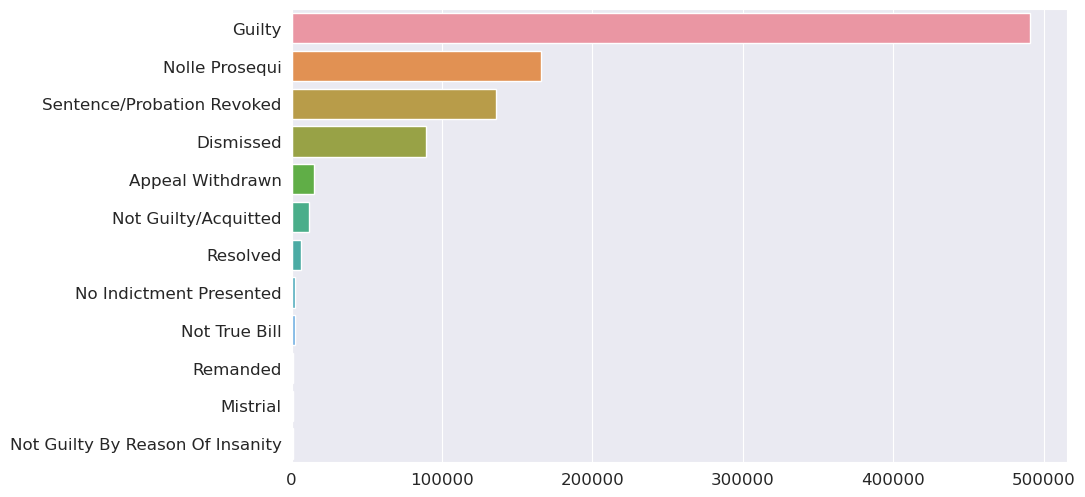

In [22]:
hearing_result_counts = df['final_disposition'].value_counts()
subset = hearing_result_counts[:15]
sns.barplot(y=subset.index, x=subset.values)

### Top 20 final_disposition by gender

<AxesSubplot:xlabel='total', ylabel='final_disposition'>

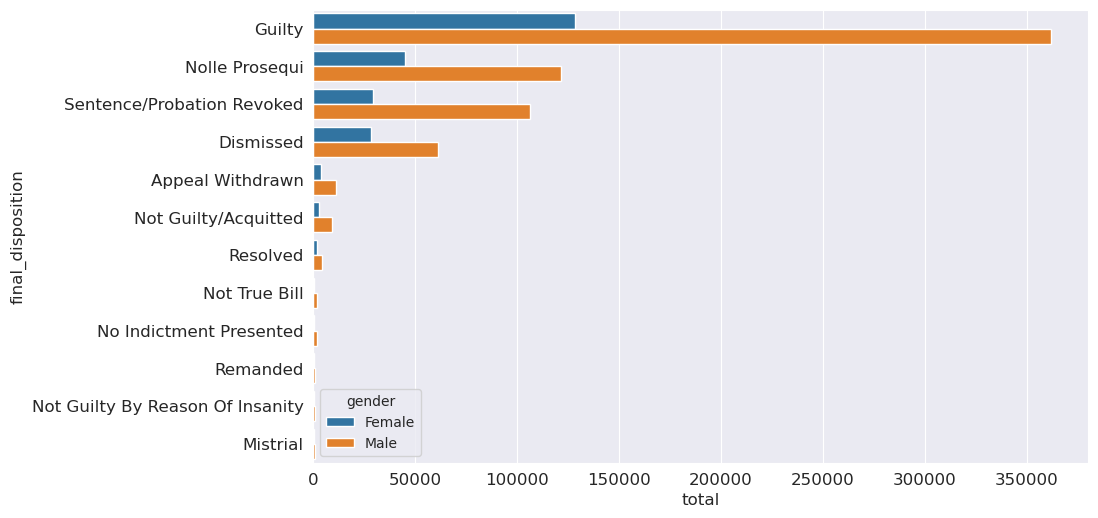

In [23]:
df_result_bygendger = df.groupby(['final_disposition', 'gender'])\
                        .size()\
                        .unstack()\
                        .fillna(0)\
                        .sort_values(['Female', 'Male'], ascending=False)
df_stacked = df_result_bygendger.head(15).stack()
df_stacked.name = 'total'
df_stacked= df_stacked.reset_index()
sns.barplot(x='total', y='final_disposition', hue='gender', data= df_stacked)

In [24]:
df['final_disposition'].unique()

array(['Appeal Withdrawn', 'Guilty', 'Nolle Prosequi',
       'Not Guilty/Acquitted', 'Dismissed', 'Sentence/Probation Revoked',
       'Not Guilty By Reason Of Insanity', 'No Indictment Presented',
       'Remanded', 'Mistrial', 'Not True Bill', 'Resolved'], dtype=object)

In [25]:
df['gender'].value_counts()

Male      680611
Female    240368
Name: gender, dtype: int64

In [26]:
df['class'].value_counts()

U    441202
5    148651
1    143978
6    139006
4     18905
3     15054
2     14173
O        10
Name: class, dtype: int64

In [27]:
### Delete cases with charge type other than Felony or Misdemeanor

In [28]:
#Possible values from doc metadata ChargeType “Civil” “F” “Felony” “Infraction” “Misdemeanor” “Other (Animal Violations, Bond Appeals)”
df['charge_type'].value_counts()

Felony         696437
Misdemeanor    224542
Name: charge_type, dtype: int64

---

**Create Apache Spark Session** 

In [45]:
app_name = 'va_expungement'

if RIVANA != True:
    # update spark_master to your master local IP and port
    spark_master = "spark://TRX40:7077"
    spark = SparkSession\
        .builder\
        .config('spark.executor.memory', '2g')\
        .config('spark.executor.cores', '2')\
        .config('spark.cores.max', '24')\
        .config('spark.cores.min', '20')\
        .config('spark.driver.memory', '8g')\
        .config("spark.local.dir", "C:/tmp/hive")\
        .appName(app_name)\
        .master(spark_master)\
        .getOrCreate()
elif RIVANA == True:
    spark = SparkSession \
        .builder \
        .master("local") \
        .appName(app_name) \
        .config("spark.executor.memory", '8g') \
        .config('spark.executor.cores', '4') \
        .config('spark.cores.max', '4') \
        .config("spark.driver.memory",'8g') \
        .getOrCreate()

In [46]:
file = f'{BASE_DIR}/data/circuit_court_2009_2019_cleansed.csv.gz'

schema = StructType([
    StructField('person_id', LongType(), False),
    StructField('offense_date', DateType(), False),
    StructField('final_disposition', StringType(), False),
    StructField('fips', IntegerType(), False),
    StructField('gender', StringType(), False),
    StructField('race', StringType(), False),
    StructField('class', StringType(), False),
    StructField('charge_type', StringType(), False),
    StructField('ammended_charge_type', StringType(), False),
    StructField('fips_area', StringType(), False),
])

circuit_df = (spark.read.schema(schema)
             .format("csv")
             .option("inferSchema", True)
             .option("header", True)
             .load(file))

circuit_df.show(5)

+---------------+------------+-----------------+----+------+--------------------+-----+-----------+--------------------+--------------------+
|      person_id|offense_date|final_disposition|fips|gender|                race|class|charge_type|ammended_charge_type|           fips_area|
+---------------+------------+-----------------+----+------+--------------------+-----+-----------+--------------------+--------------------+
|217101000000208|  2012-07-26| Appeal Withdrawn|  99|Female|White Caucasian (...|    1|Misdemeanor|             unknown|King George Circu...|
|357100000000310|  2012-08-12|           Guilty|  99|  Male|White Caucasian (...|    U|     Felony|             unknown|King George Circu...|
| 67070000000958|  2012-02-19|           Guilty|  99|  Male|White Caucasian (...|    6|     Felony|             unknown|King George Circu...|
|236150000000660|  2012-04-18|           Guilty|  99|  Male|Black (Non-Hispanic)|    5|     Felony|             unknown|King George Circu...|
|23615

---

# Feature Engineering

### Adding new 'repeat_offender' column
From the above analysis we see the following condition in the data  
 - The charge column is free form text, charge_type is categorical. The same person can be charges one more times on the same day or on different days on multiple counts  
 - however since we are not able to use charge as a predictor variable using only charge_types will result in multiple record for the same person (by person_id)  
 - so to minimize the noise in the data we will introduce a variable called 'repeat_offender', this will be 1 if a person has felony or otherwise  

In [47]:
# add where condition where case_type is not 
repeat_offenders = circuit_df.groupBy('person_id').count().orderBy('count', ascending=False)
repeat_offenders = repeat_offenders.withColumnRenamed("count", "rpt_offense_ct")

# create temporary views
circuit_df.createOrReplaceTempView("cc_case")
repeat_offenders.createOrReplaceTempView("cc_rpt_offender")

circuit_df = circuit_df.join(repeat_offenders,circuit_df.person_id ==  repeat_offenders.person_id,"left")

# create a repeat_offender column when repeat_offense_ct is greater than 1 
# and drop the repeat_offense_ct column
circuit_df = circuit_df\
    .withColumn('repeat_offender', expr("CASE WHEN rpt_offense_ct > 1 THEN 1 ELSE 0 END"))\
    .drop('rpt_offense_ct')

#create or replce cc_case
circuit_df.createOrReplaceTempView("cc_case")

In [48]:
circuit_df.show(2)

+---------------+------------+-----------------+----+------+--------------------+-----+-----------+--------------------+--------------------+---------------+---------------+
|      person_id|offense_date|final_disposition|fips|gender|                race|class|charge_type|ammended_charge_type|           fips_area|      person_id|repeat_offender|
+---------------+------------+-----------------+----+------+--------------------+-----+-----------+--------------------+--------------------+---------------+---------------+
|217101000000208|  2012-07-26| Appeal Withdrawn|  99|Female|White Caucasian (...|    1|Misdemeanor|             unknown|King George Circu...|217101000000208|              1|
|357100000000310|  2012-08-12|           Guilty|  99|  Male|White Caucasian (...|    U|     Felony|             unknown|King George Circu...|357100000000310|              0|
+---------------+------------+-----------------+----+------+--------------------+-----+-----------+--------------------+----------

### Adding new 'candidate' column (Response Variable)

if the final_disposition of the case is in the list ['Dismissed','Noile Prosequi','Not Guilty', 'Withdrawn', 'Not Found', 'No Indictment Presented', 'No Longer Under Advisement', 'Not True Bill']
then we set **candidate** column value to 1 else to 0.

In [49]:
# Adding a candidate column
candidate_udf = udf(encode_expungement_candidate, IntegerType())
circuit_df = circuit_df.withColumn('candidate', candidate_udf('final_disposition'))

# Create or replace cc_caste view
circuit_df.createOrReplaceTempView("cc_case")

circuit_df.show(2)

+---------------+------------+-----------------+----+------+--------------------+-----+-----------+--------------------+--------------------+---------------+---------------+---------+
|      person_id|offense_date|final_disposition|fips|gender|                race|class|charge_type|ammended_charge_type|           fips_area|      person_id|repeat_offender|candidate|
+---------------+------------+-----------------+----+------+--------------------+-----+-----------+--------------------+--------------------+---------------+---------------+---------+
|217101000000208|  2012-07-26| Appeal Withdrawn|  99|Female|White Caucasian (...|    1|Misdemeanor|             unknown|King George Circu...|217101000000208|              1|        0|
|357100000000310|  2012-08-12|           Guilty|  99|  Male|White Caucasian (...|    U|     Felony|             unknown|King George Circu...|357100000000310|              0|        0|
+---------------+------------+-----------------+----+------+--------------------

### Adding a new column 'case_charge_type_enc' 

By encoding case and charge type

In [50]:
encode_udf = udf(encode_class_and_chargetype, IntegerType())
circuit_df = circuit_df.withColumn('case_charge_type_enc', encode_udf('class', 'charge_type'))

#create or replace cc_caste view
circuit_df.createOrReplaceTempView("cc_case")

circuit_df.show(2)

+---------------+------------+-----------------+----+------+--------------------+-----+-----------+--------------------+--------------------+---------------+---------------+---------+--------------------+
|      person_id|offense_date|final_disposition|fips|gender|                race|class|charge_type|ammended_charge_type|           fips_area|      person_id|repeat_offender|candidate|case_charge_type_enc|
+---------------+------------+-----------------+----+------+--------------------+-----+-----------+--------------------+--------------------+---------------+---------------+---------+--------------------+
|217101000000208|  2012-07-26| Appeal Withdrawn|  99|Female|White Caucasian (...|    1|Misdemeanor|             unknown|King George Circu...|217101000000208|              1|        0|                   4|
|357100000000310|  2012-08-12|           Guilty|  99|  Male|White Caucasian (...|    U|     Felony|             unknown|King George Circu...|357100000000310|              0|       

In [51]:
circuit_df.printSchema()

root
 |-- person_id: long (nullable = true)
 |-- offense_date: date (nullable = true)
 |-- final_disposition: string (nullable = true)
 |-- fips: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- race: string (nullable = true)
 |-- class: string (nullable = true)
 |-- charge_type: string (nullable = true)
 |-- ammended_charge_type: string (nullable = true)
 |-- fips_area: string (nullable = true)
 |-- person_id: long (nullable = true)
 |-- repeat_offender: integer (nullable = false)
 |-- candidate: integer (nullable = true)
 |-- case_charge_type_enc: integer (nullable = true)



In [54]:
circuit_df.toPandas().to_csv(
    PROCESSED_PATH + "circuit_court_2009_2019_transformed.csv.gz",
    index=False,
    compression="gzip",
    header=True,
    quotechar='"',
    doublequote=True,
    line_terminator="\n",
)

---

# Model Training

## Creating Training and Test Datasets

In [55]:
sampled_cricuit_df = downsample(circuit_df)
sampled_cricuit_df.groupBy('candidate').count().show()

majority class count: 827504
minority class count: 93475
sampling ratio : 8.85267718641348
+---------+-----+
|candidate|count|
+---------+-----+
|        1|93475|
|        0|93770|
+---------+-----+



In [57]:
# select a subset of columns from the dataset
sub_circuit_df = sampled_cricuit_df.select("gender", "race", "repeat_offender", "case_charge_type_enc", "candidate")
train_df, test_df = sub_circuit_df.randomSplit([0.8, 0.2], seed=42)

## Creating Pipelines

In [155]:
# create a list of all categorical colums
categorical_cols = [field for (field, dataType) in sub_circuit_df.dtypes if dataType == 'string']

# Note:  String indexer converts the categorical values into category indexes ordered by label frequencies 
# so most frequent labels gets 0 which provides us with reproducible results across the various runs of the same data

# create a list of indexed columns as output cols for string indexer
index_output_cols = [x + "Index" for x in categorical_cols]

# Note: Once you have created your category indecies, pass those to OneHotEncoder, it maps categorical indices into 
# a column of binary vectors

# create a list of indexed columns as output cols for one hot encoding
ohe_output_cols = [x + "OHE" for x in categorical_cols]

string_indexer = StringIndexer(inputCols=categorical_cols,
                             outputCols=index_output_cols,
                             handleInvalid='skip')

ohe_encoder = OneHotEncoder(inputCols=index_output_cols, outputCols=ohe_output_cols)

numeric_cols = [field for (field, dataType) in sub_circuit_df.dtypes if ((dataType == 'int') & (field != 'candidate'))]

assembler_inputs = ohe_output_cols + numeric_cols

vec_assembler = VectorAssembler(inputCols = assembler_inputs, outputCol="features")

# createlogistic regression model
lr = LogisticRegression(maxIter=10,
        regParam=0.01, 
        labelCol='candidate')

# Create Decision Tree model
dt = DecisionTreeClassifier(labelCol='candidate', 
                            featuresCol="features")

# Create lr_pipeline
stages = [string_indexer, ohe_encoder, vec_assembler, lr]
lr_pipeline = Pipeline(stages = stages)

# Create dt_pipeline
stages2 = [string_indexer, ohe_encoder, vec_assembler, dt]
dt_pipeline = Pipeline(stages = stages2)

## Pipeline Model Training

In [157]:
lr_pipeline_model = lr_pipeline.fit(train_df)
dt_pipeline_model = dt_pipeline.fit(train_df)

## Evaluating Model : Logistic Regression

In [158]:
lr_pipeline_pred = lr_pipeline_model.transform(test_df)
dt_pipeline_pred = dt_pipeline_model.transform(test_df)

In [174]:
print("\nLogistic Regression Model:")
lr_pipeline_pred.select(['candidate','rawPrediction','probability','prediction']).show(2,False)

print("\nDecision Tree Model:")
dt_pipeline_pred.select(['candidate','rawPrediction','probability','prediction']).show(2,False)


Logistic Regression Model:
+---------+----------------------------------------+---------------------------------------+----------+
|candidate|rawPrediction                           |probability                            |prediction|
+---------+----------------------------------------+---------------------------------------+----------+
|0        |[0.2849828194371643,-0.2849828194371643]|[0.5707674027995937,0.4292325972004063]|0.0       |
|0        |[0.6818198657794875,-0.6818198657794875]|[0.664144751481597,0.335855248518403]  |0.0       |
+---------+----------------------------------------+---------------------------------------+----------+
only showing top 2 rows


Decision Tree Model:
+---------+-----------------+----------------------------------------+----------+
|candidate|rawPrediction    |probability                             |prediction|
+---------+-----------------+----------------------------------------+----------+
|0        |[3210.0,3407.0]  |[0.4851141000453378,0.5148

In [170]:
evaluate_model(lr_pipeline_pred)

The auroc value of Logistic Regression Model is 0.6584126582019573
The aupr value of Logistic Regression Model is 0.664435363564665
The Accuracy of Logistic Regression : 0.625237166296999
False Positive :  5883
True Positive :  10420
False Negative :  8141
True Negative :  12977
Logistic Regression model Acccuracy: 0.625237166296999
              precision    recall  f1-score   support

           0       0.61      0.69      0.65     18860
           1       0.64      0.56      0.60     18561

    accuracy                           0.63     37421
   macro avg       0.63      0.62      0.62     37421
weighted avg       0.63      0.63      0.62     37421

Logistic Regression Confusion Matrix:
 [[12977  5883]
 [ 8141 10420]]


In [171]:
evaluate_model(dt_pipeline_pred, model_name='Decision Tree')

The auroc value of Decision Tree Model is 0.3875972482010679
The aupr value of Decision Tree Model is 0.4236900367362135
The Accuracy of Decision Tree : 0.6422329707918014
False Positive :  3820
True Positive :  8993
False Negative :  9568
True Negative :  15040
Decision Tree model Acccuracy: 0.6422329707918014
              precision    recall  f1-score   support

           0       0.61      0.80      0.69     18860
           1       0.70      0.48      0.57     18561

    accuracy                           0.64     37421
   macro avg       0.66      0.64      0.63     37421
weighted avg       0.66      0.64      0.63     37421

Decision Tree Confusion Matrix:
 [[15040  3820]
 [ 9568  8993]]


## Cross-Validation :Logistic Regression

In [111]:
# cross validation 
param_grid = (ParamGridBuilder()
              .addGrid(lr.regParam, [0.01, 0.1, 0.5,2.0]) #regularization parameter
              .addGrid(lr.elasticNetParam, [0.0, 0.5,1.0]) #Elastic Net Parameter (Ridge = 0)
              .addGrid(lr.maxIter, [1,5,10])
              .build())

cv = CrossValidator(estimator=pipeline, estimatorParamMaps = param_grid, evaluator = lr_evaluator, numFolds=5)

cvModel = cv.fit(train_df)

In [175]:
lr_cv_pred = cvModel.transform(test_df)
evaluate_model(lr_cv_pred, model_name=" Logistic Regiression with CV")

The auroc value of  Logistic Regiression with CV Model is 0.6590861747139339
The aupr value of  Logistic Regiression with CV Model is 0.6637288719582055
The Accuracy of  Logistic Regiression with CV : 0.5059993052029609
False Positive :  51
True Positive :  126
False Negative :  18435
True Negative :  18809
 Logistic Regiression with CV model Acccuracy: 0.5059993052029609
              precision    recall  f1-score   support

           0       0.51      1.00      0.67     18860
           1       0.71      0.01      0.01     18561

    accuracy                           0.51     37421
   macro avg       0.61      0.50      0.34     37421
weighted avg       0.61      0.51      0.34     37421

 Logistic Regiression with CV Confusion Matrix:
 [[18809    51]
 [18435   126]]


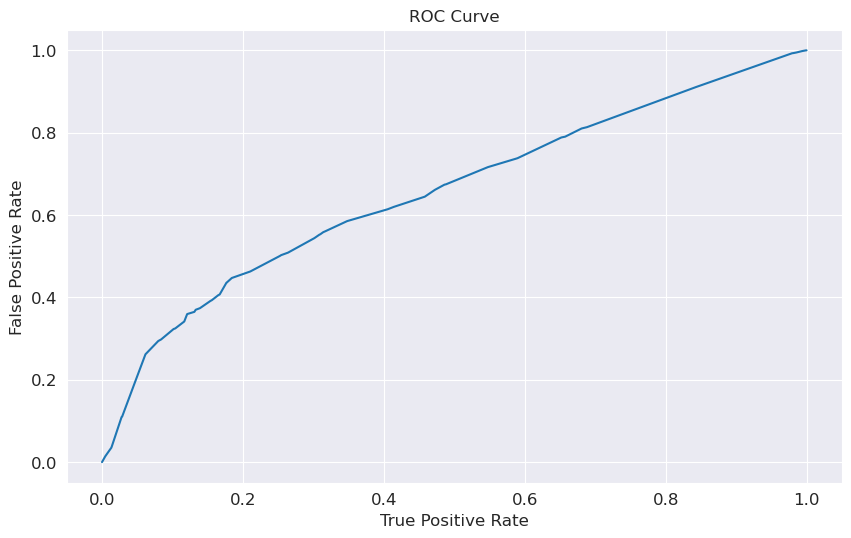

Training set areaUnderROC: 0.6545782118152179


In [136]:
best_model = cvModel.bestModel.stages[-1] # last element in the pipeline stages is the Lr_model
trainingSummary = best_model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

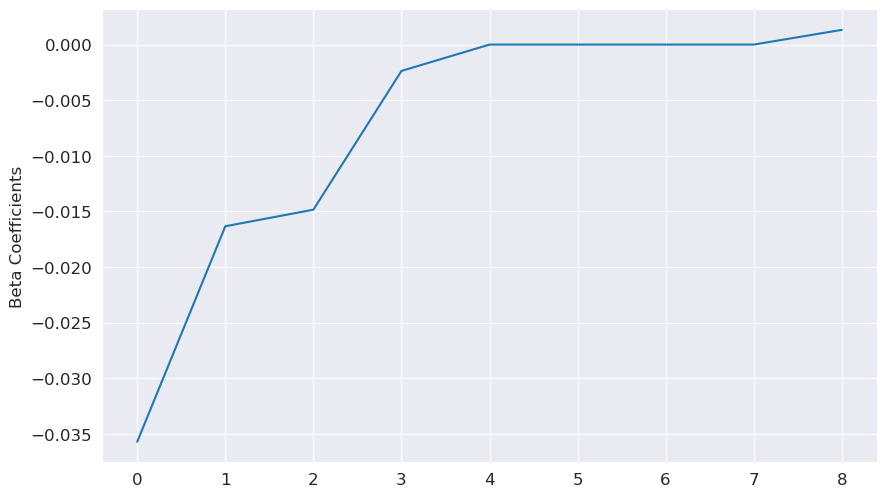

In [139]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(best_model.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

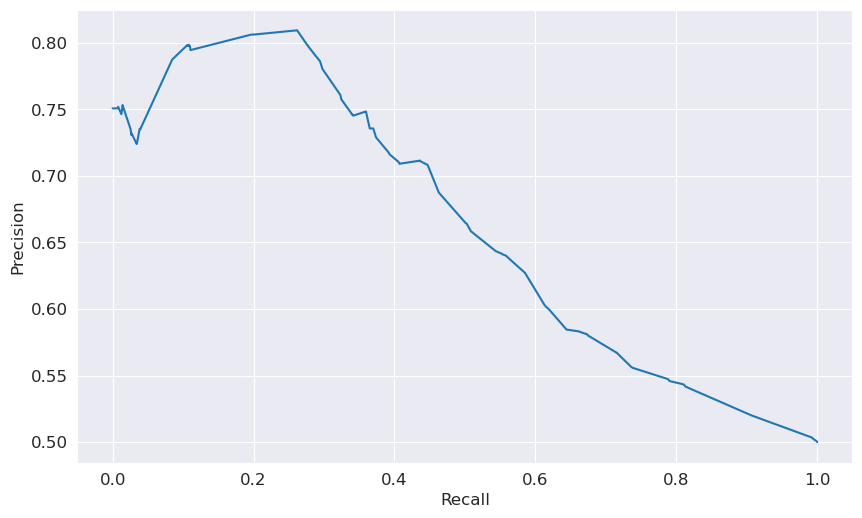

In [140]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

## 4.0 Model Training

## 5.0 Predictions

## 6.0 Conclusions

In [ ]:
#!jupyter nbconvert va_circuit_court_expungment.ipynb --to pdf